In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

import matplotlib.pyplot as plt
import jax

In [55]:
T=1.
N=100
dim=2
num_pts = 11
alpha=0.1
sigma=1.0
grid_size = 5
grid_range = (-1, 2.)

forward_init = sample_ellipse(num_pts)
kunita_sde = sdes.gaussian_independent_kernel_sde(T, N, dim, num_pts, alpha, sigma, grid_range, grid_size)

In [56]:
key = jax.random.PRNGKey(2)
forward_trajs= kunita_sde.simulate_trajectories(forward_init, 2, key)

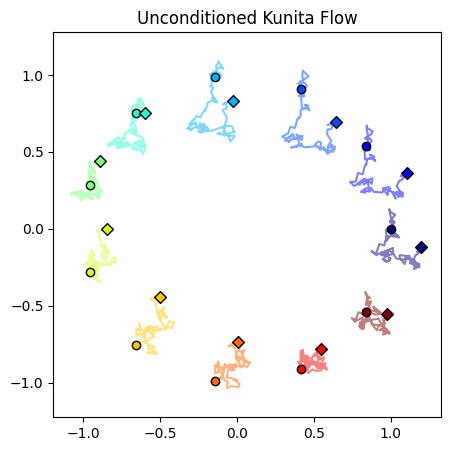

In [57]:
from sdebridge.plotting import plot_single_trajectory

traj = forward_trajs[0].reshape(-1, num_pts*dim)
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [58]:
from sdebridge.networks.score_unet import ScoreUNet

neural_net = ScoreUNet

network = {
    "output_dim": kunita_sde.dim*kunita_sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    
training= {
    "batch_size": 100,
    "load_size": 1000,
    "num_epochs": 50,
    "learning_rate": 5e-3,
    "warmup_steps": 0,
}

target = sample_ellipse(num_pts)
train_key = jax.random.split(key, 2)[0]
score_state_p = db.learn_p_score(kunita_sde, target, train_key, **training, net=neural_net, network_params=network)

Training:  10%|█         | 5/50 [00:33<04:59,  6.65s/epoch, Epoch=5, loss=10.7332]


KeyboardInterrupt: 

In [22]:
initial_val = sample_ellipse(num_pts, scale=1.2)
score_p = score_fn(score_state_p)
reverse_sde = sdes.reverse(kunita_sde, score_p)
backward_trajs = sdes.simulate_traj(reverse_sde, initial_val, 2, train_key)


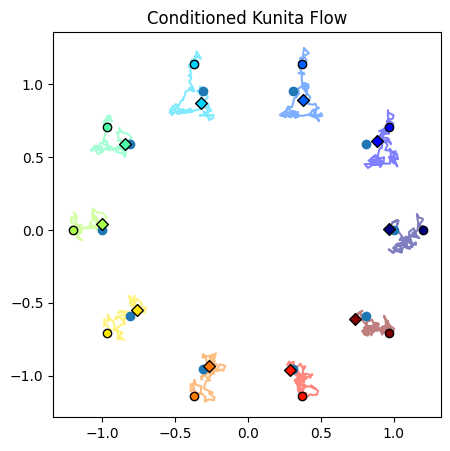

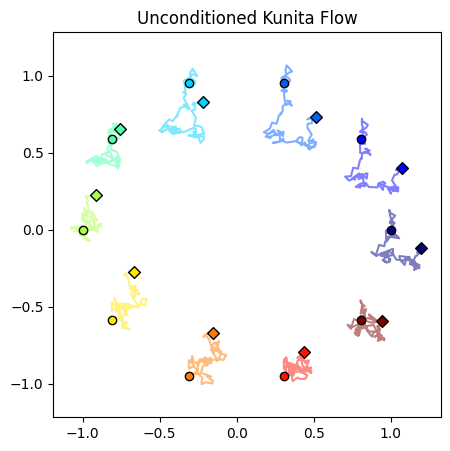

In [24]:
plt_init = target.reshape((-1, 2))

traj = backward_trajs[0].reshape(-1, num_pts*dim)
plot_single_trajectory(traj, "Conditioned Kunita Flow")
plt_target = target.reshape((num_pts, 2))
plt.scatter(plt_init[:, 0], plt_init[:, 1])
traj = forward_trajs[0].reshape(-1, num_pts*dim)
plot_single_trajectory(traj, "Unconditioned Kunita Flow")